In [139]:
import string
import spacy
spacy_nlp = spacy.load("en_core_web_sm")
import numpy as np
from spacy.lang.en.stop_words import STOP_WORDS
import utility_functions as utils
import importlib
import pandas as pd
import matplotlib.pyplot as plt

# Octis is the library which can use different implemented topic modelling techniques
from octis.preprocessing.preprocessing import Preprocessing
from octis.evaluation_metrics.coherence_metrics import Coherence
from octis.evaluation_metrics.diversity_metrics import TopicDiversity
from octis.models.CTM import CTM

importlib.reload(utils)

data = '/Users/borosabel/Documents/Uni/Thesis/PopMIR/Data/Audio/test.json'

custom_stop_words = list(STOP_WORDS)  # Existing stop words
custom_stop_words.extend(["ll", "ve", "'em", "em"])  # Add problematic tokens

In [116]:
# Initialize preprocessing
preprocessor = Preprocessing(
    vocabulary=None,
    max_features=None,
    remove_punctuation=True,
    punctuation=string.punctuation,
    lemmatize=True,
    stopword_list=custom_stop_words,
    min_chars=2,
    min_words_docs=0,
    save_original_indexes=True,
    min_df=0.1, # a term must appear in at least 10% of the documents; otherwise, it will be discarded.
    max_df=0.8, # a term appearing in more than 80% of the documents will be discarded, as it might be too common and potentially less informative.
    split=False # We don't want train, validation and test split
)

dataset = preprocessor.preprocess_dataset(documents_path="/Users/borosabel/Documents/Uni/Thesis/PopMIR/Code/Lyrics/octis_dataset/corpus.tsv")

100%|██████████| 1518/1518 [02:18<00:00, 10.97it/s]


created vocab
294


In [118]:
# I save the dataset because it exports a file called indexes.txt. It is important because during the preprocessing steps the preprocessor
# can get rid of a few documents if they don't have enough words or maybe they are too short. (For example intro files).
# I can load the indexes.txt file and use it as a list of indexes and apply it on the original dataframe so I don't have size mismatch.
dataset.save('./')

In [120]:
model = CTM(num_topics=5, inference_type="combined", num_epochs=200, use_partitions=False, bert_model="bert-base-nli-mean-tokens")
model_output = model.train_model(dataset)

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

In [121]:
model_output['topics'][0] # Vulgarity

['fuck',
 'bitch',
 'hoe',
 'shit',
 'ass',
 'nigga',
 'dick',
 'cause',
 'fuckin',
 'big']

In [122]:
model_output['topics'][1] # 

['buy',
 'mad',
 'grow',
 'spot',
 'blood',
 'close',
 'kill',
 'dough',
 'deep',
 'act']

In [123]:
model_output['topics'][2] # Romance

['girl', 'man', 'baby', 'love', 'good', 'let', 'world', 'head', 'look', 'hey']

In [124]:
model_output['topics'][3] # Music

['rhyme',
 'hear',
 'sucker',
 'stop',
 'wanna',
 'mc',
 'style',
 'rap',
 'run',
 'sound']

In [125]:
model_output['topics'][4] # Day, Street-Life, Struggle

['nigga', 'life', 'die', 'live', 'shit', 'god', 'feel', 'real', 'day', 'fuck']

In [126]:
coherence = Coherence(texts=dataset.get_corpus(), topk=10)  # Adjust 'topk' as needed

# Setting up Diversity Metric
topic_diversity = TopicDiversity(topk=10)

# Calculate Metrics
coherence_score = coherence.score(model_output)
diversity_score = topic_diversity.score(model_output)

print("Coherence Score:", coherence_score)
print("Diversity Score:", diversity_score)

Coherence Score: 0.02582505361354096
Diversity Score: 0.94


<b>Let's check which document belongs mostly to which topic</b>

In [127]:
model_output['topic-document-matrix']

array([[0.24009347, 0.5611452 , 0.10512698, ..., 0.21850696, 0.30074646,
        0.33027242],
       [0.25437325, 0.07992493, 0.08792994, ..., 0.05265627, 0.10948011,
        0.13697892],
       [0.2004063 , 0.05479581, 0.14398267, ..., 0.07164645, 0.22313941,
        0.05525054],
       [0.15912314, 0.05730996, 0.57122545, ..., 0.04900964, 0.18121383,
        0.0520007 ],
       [0.14600383, 0.24682411, 0.09173495, ..., 0.60818067, 0.1854202 ,
        0.42549741]])

In [128]:
# We decide on the topic based on the maximum probability of the topic.
dominant_topic_indices = np.argmax(model_output['topic-document-matrix'], axis=0)

In [129]:
# Every row is a document and the colum shows which is the most probable topic index.
dominant_topic_indices

array([1, 0, 3, ..., 4, 0, 4])

In [130]:
df = utils.get_all_artist_lyrics(data) # Original data

In [131]:
# Path to the file containing indices
file_path = 'indexes.txt'

# Read the file and convert each line to an integer
with open(file_path, 'r') as file:
    indices = [int(line.strip()) for line in file]

In [132]:
df

,Coast,Artist,Album,Album Release Year,Song,Lyrics
0,east_coast,big_l,Lifestylez Ov Da Poor and Dangerous (1995),1995,Fed_Up_With_the_Bullshit,"\n\n[VERSE 1]\nYo, on the scene is the brother..."
1,east_coast,big_l,Lifestylez Ov Da Poor and Dangerous (1995),1995,All_Black,"\n\n[Big L:]\nYo once again it's the Big L, th..."
2,east_coast,big_l,Lifestylez Ov Da Poor and Dangerous (1995),1995,Street_Struck,"\n\n[Big L]\nYeah, it's the Big L\nComin at yo..."
3,east_coast,big_l,Lifestylez Ov Da Poor and Dangerous (1995),1995,M_V_P_,\n\n[Big L]\n A yo spark up the phillies and p...
4,east_coast,big_l,Lifestylez Ov Da Poor and Dangerous (1995),1995,No_Endz__No_Skinz,\n\n[Verse 1:]\nLet me get to the point real q...
...,...,...,...,...,...,...
1513,west_coast,mack_10,Mack 10 (1995),1995,Wanted_Dead,\n\nOn a high speed chase they recognize my pl...
1514,west_coast,mack_10,Mack 10 (1995),1995,H_O_E_K,\n\n[Intro: Ice Cube]\nOh\nShake your ass\nK-D...
1515,west_coast,mack_10,Mack 10 (1995),1995,Westside_Slaughterhouse,\n\n[Mack 10]\nMicrophone check I.O. from the ...
1516,west_coast,mack_10,Mack 10 (1995),1995,On_Them_Thangs,\n\nWhen in the streets I keep my heat on my s...


In [134]:
filtered_df = df.iloc[indices]

In [135]:
filtered_df.shape[0] == dominant_topic_indices.shape[0]

True

In [136]:
filtered_df['Topic Model'] = dominant_topic_indices

/var/folders/99/617f3z715_g8nc26tll89ddc0000gn/T/ipykernel_27757/1676926741.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Topic Model'] = dominant_topic_indices


In [137]:
filtered_df.head()

,Coast,Artist,Album,Album Release Year,Song,Lyrics,Topic Model
0,east_coast,big_l,Lifestylez Ov Da Poor and Dangerous (1995),1995,Fed_Up_With_the_Bullshit,"\n\n[VERSE 1]\nYo, on the scene is the brother...",1
1,east_coast,big_l,Lifestylez Ov Da Poor and Dangerous (1995),1995,All_Black,"\n\n[Big L:]\nYo once again it's the Big L, th...",0
2,east_coast,big_l,Lifestylez Ov Da Poor and Dangerous (1995),1995,Street_Struck,"\n\n[Big L]\nYeah, it's the Big L\nComin at yo...",3
3,east_coast,big_l,Lifestylez Ov Da Poor and Dangerous (1995),1995,M_V_P_,\n\n[Big L]\n A yo spark up the phillies and p...,0
4,east_coast,big_l,Lifestylez Ov Da Poor and Dangerous (1995),1995,No_Endz__No_Skinz,\n\n[Verse 1:]\nLet me get to the point real q...,3


In [138]:
topic_coast_distribution = pd.crosstab(filtered_df['Topic Model'], filtered_df['Coast'])
print(topic_coast_distribution)

Coast        east_coast  west_coast
Topic Model                        
0                    43         249
1                   200         133
2                   128         101
3                   232         109
4                   153         162


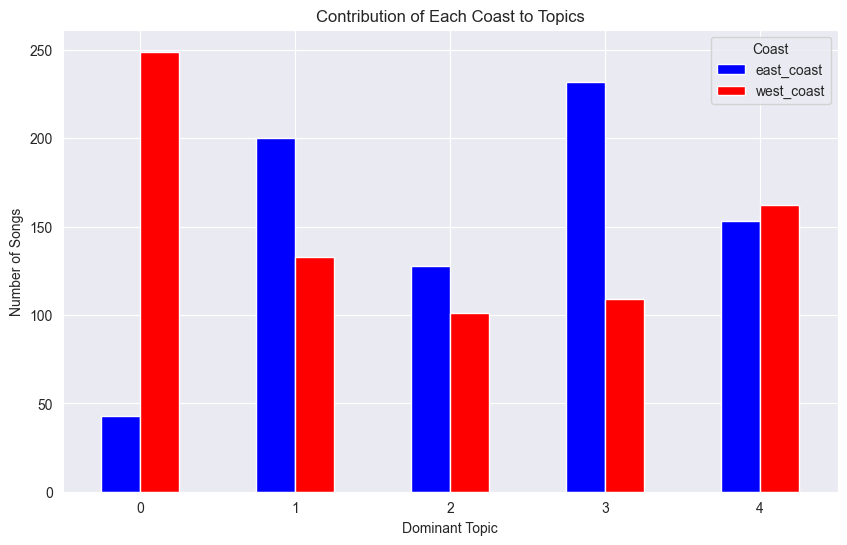

In [141]:
colors = ['blue', 'red']
# Plotting a grouped bar chart
topic_coast_distribution.plot(kind='bar', figsize=(10, 6), color=colors)
plt.title('Contribution of Each Coast to Topics')
plt.xlabel('Dominant Topic')
plt.ylabel('Number of Songs')
plt.xticks(rotation=0)
plt.legend(title='Coast')
plt.show()

In [142]:
df_artists_only = filtered_df[['Artist', 'Topic Model']]

In [144]:
artist_topic_distribution = pd.crosstab(df_artists_only['Artist'], df_artists_only['Topic Model'])
print(artist_topic_distribution)

Topic Model            0   1   2   3   4
Artist                                  
Dr.Dre                 9   2   5   3  10
a_tribe_called_quest   1  25  15  14   2
beastie_boys           4  38  20  26   0
big_l                  4   1   1   4   2
busta_rhymes           3   2   8   1  32
coolio                16  16   6   3   8
cypress_hill          12  16   9   5   7
de_la_soul             0  34  26  28   2
digital_underground    1  15  11  20   0
eazy_e                20   4   3   8   9
erikb_&_rakim          1   8   1  29   0
gang_starr             2  18   2  32   4
ice-t                 20  25  12  18  13
ice_cube              38  21   3   1   3
jay-z                 11   3   2   3  24
ll_cool_j              0  13  26  33   4
luniz                 10   1   0   0   3
mack_10                9   1   0   1   3
mobb_deep              2   5   1   2  30
nas                    0   0   4   3  18
nwa                   23   3   4   4   8
pac                   12   3  24  13  70
public_enemy    

/var/folders/99/617f3z715_g8nc26tll89ddc0000gn/T/ipykernel_27757/1413891858.py:11: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.barplot(x='Artist', y='Number of Songs', hue='Topic Model', data=df_melted, palette=palette)


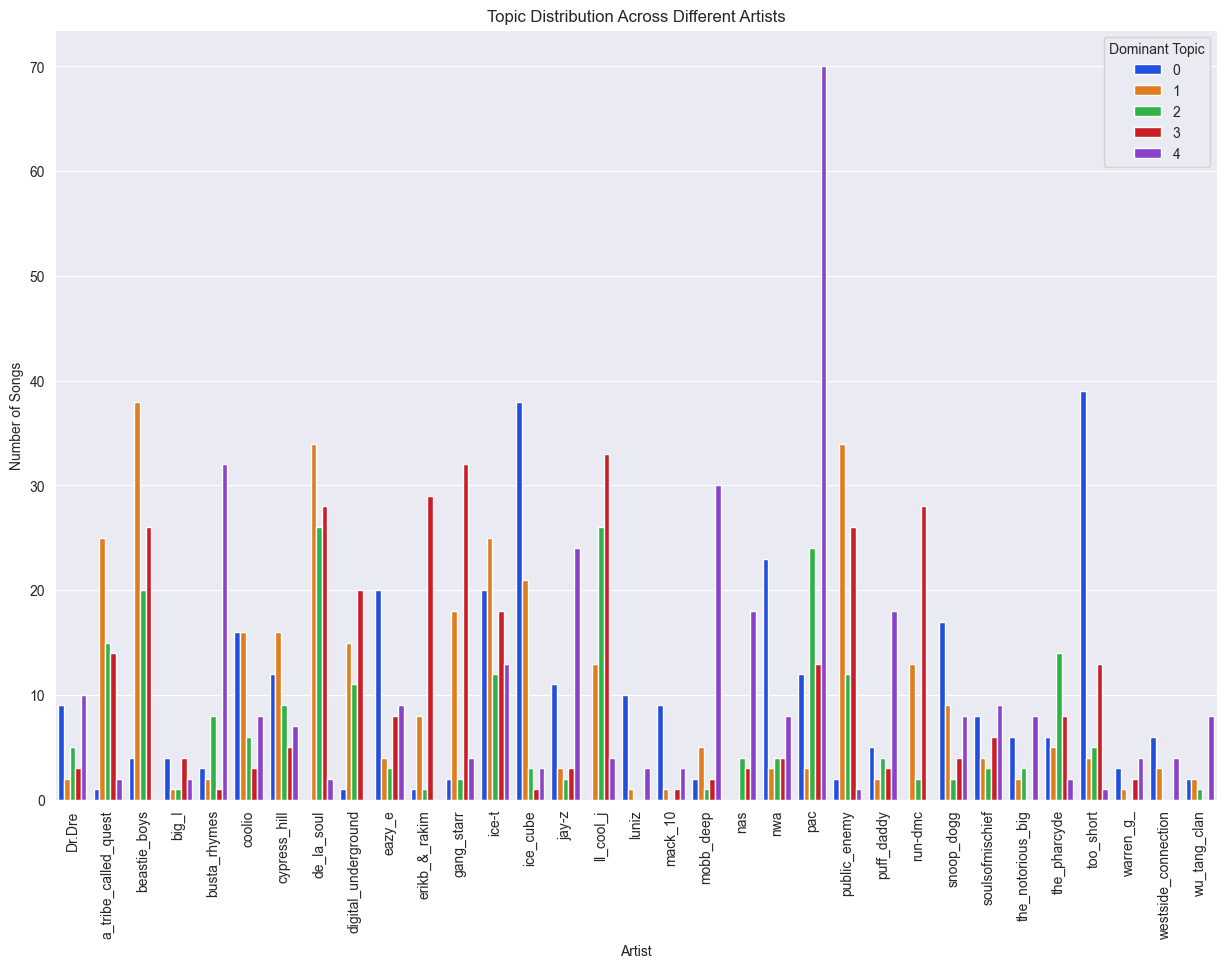

In [152]:
import seaborn as sns

# Reset index to use "Artist" as a normal column
df_melted = artist_topic_distribution.reset_index().melt(id_vars='Artist', value_name='Number of Songs', var_name='Topic Model')

# Using a predefined palette
palette = sns.color_palette("bright")  # You can change "pastel" to "deep", "muted", "bright", "dark", or "colorblind"

# Create the plot
plt.figure(figsize=(15, 10))
sns.barplot(x='Artist', y='Number of Songs', hue='Topic Model', data=df_melted, palette=palette)
plt.title('Topic Distribution Across Different Artists')
plt.xlabel('Artist')
plt.ylabel('Number of Songs')
plt.xticks(rotation=90)  # Rotate labels to make them readable
plt.legend(title='Dominant Topic')
plt.show()

In [155]:
topic_word_matrix = model_output['topic-word-matrix']

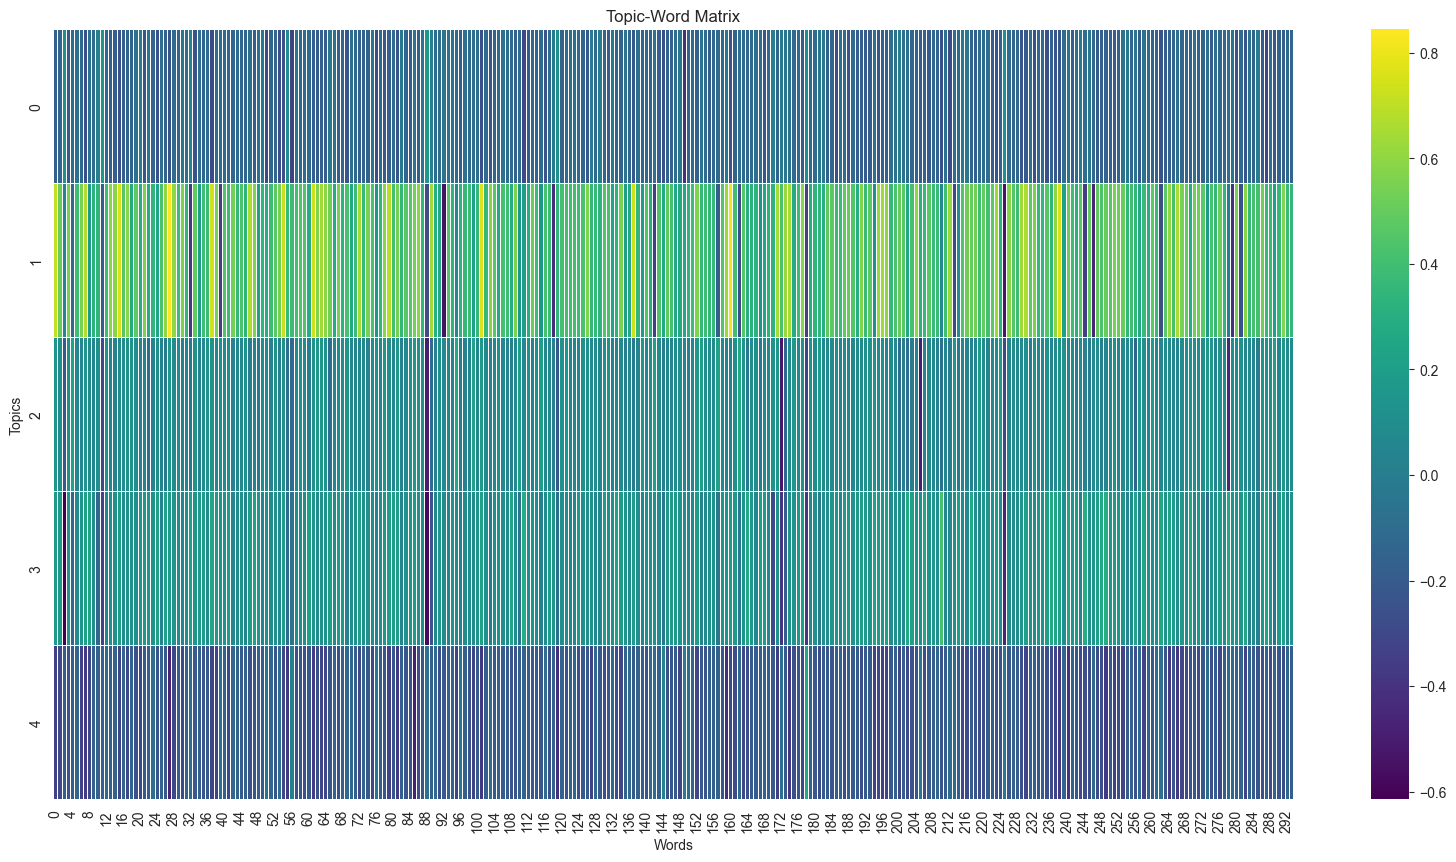

In [158]:
plt.figure(figsize=(20, 10))
sns.heatmap(topic_word_matrix, cmap='viridis', linewidths=.5)
plt.title('Topic-Word Matrix')
plt.xlabel('Words')
plt.ylabel('Topics')
plt.show()